## Notebook 3: Model Training and Evaluation

**Objective:** The goal of this notebook is to train our Reinforcement Learning agent, evaluate its performance on unseen data (a backtest), and compare it to a simple "Buy and Hold" benchmark.

**Process:**
1.  **Setup:** Re-define the complete `TradingEnv` class and load the dataset.
2.  **Split Data:** Divide our 10-year dataset into a `train_df` (e.g., 2015-2022) and a `test_df` (e.g., 2023-2025). This is **critical** for a valid backtest.
3.  **Instantiate Environments:** Create one `TradingEnv` for training and another for testing.
4.  **Define Model:** Choose our algorithm (PPO) and its configuration.
5.  **Train Model:** Run the `.learn()` method on the training environment.
6.  **Backtest:** Run the trained agent on the test environment (unseen data).
7.  **Benchmark:** Create a simple "Buy and Hold" strategy for comparison.
8.  **Analyze Results:** Plot the agent's performance against the benchmark.

First, we must set up our environment. This cell contains all the code necessary to run our training notebook:

1.  Installs all required libraries (`gymnasium`, `stable-baselines3`).
2.  Imports all necessary modules (`pandas`, `numpy`, `gym`, `PPO`, etc.).
3.  Loads our cleaned data (`sp500_top5_prices_2015_2025.csv`).
4.  Defines the **complete, final version** of our `TradingEnv` class (v3), which passed all checks in the previous notebook.

This makes our notebook self-contained.

In [1]:
# --- 1. Install Libraries ---
!pip install gymnasium stable-baselines3[extra] matplotlib -q

# --- 2. Import All Libraries ---
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# --- 3. Load Processed Data ---
FILE_PATH = 'sp500_top5_prices_2015_2025.csv'
try:
    data = pd.read_csv(FILE_PATH, index_col='Date', parse_dates=True)
    TICKERS = data.columns.tolist()
    print("Data loaded successfully.")
    print(f"Tickers: {TICKERS}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise e

# --- 4. Define the Complete Trading Environment Class (v3) ---
class TradingEnv(gym.Env):
    """
    A custom Gymnasium environment for Deep RL Portfolio Optimization.
    v3: Implements softmax actions [-1, 1] and float-cast reward.
    """

    def __init__(self, df, initial_balance=100000, transaction_cost=0.001):
        super(TradingEnv, self).__init__()

        # --- Environment Parameters ---
        self.df = df
        self.n_stocks = len(self.df.columns)
        self.max_steps = len(self.df) - 1

        # --- Trading Parameters ---
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost

        # --- Action Space (Softmax Logits) ---
        self.action_space = spaces.Box(low=-1.0, high=1.0,
                                       shape=(self.n_stocks,), dtype=np.float32)

        # --- Observation Space ([cash] + [shares] + [prices]) ---
        state_shape = 1 + self.n_stocks + self.n_stocks
        low_bounds = np.zeros(state_shape, dtype=np.float32)
        low_bounds[0] = -np.inf  # Allow cash balance to be negative
        high_bounds = np.full(state_shape, np.inf, dtype=np.float32)
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds,
                                            dtype=np.float32)

        # --- Initial (Empty) State Variables ---
        self.current_step = 0
        self.balance = 0.0
        self.shares_owned = np.zeros(self.n_stocks, dtype=np.float32)
        self.portfolio_value = 0.0
        self.total_fees = 0.0
        self.portfolio_history = []


    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_owned = np.zeros(self.n_stocks, dtype=np.float32)
        self.portfolio_value = self.initial_balance
        self.total_fees = 0.0
        self.portfolio_history = [self.portfolio_value]
        observation = self._get_observation()
        info = {}
        return observation, info


    def _get_observation(self):
        prices = self.df.iloc[self.current_step].values.astype(np.float32)
        obs = np.concatenate([
            np.array([self.balance], dtype=np.float32),
            self.shares_owned,
            prices
        ])
        return obs


    def step(self, action):

        prev_portfolio_value = self.portfolio_value

        # --- Apply Softmax to action ---
        action_exp = np.exp(action - np.max(action)) # Subtract max for numerical stability
        normalized_action = action_exp / np.sum(action_exp)

        current_prices = self.df.iloc[self.current_step].values.astype(np.float32)

        target_dollar_value = self.portfolio_value * normalized_action

        current_prices[current_prices == 0] = 1e-10
        target_shares = target_dollar_value / current_prices

        shares_to_trade = target_shares - self.shares_owned

        cost_of_trades = (shares_to_trade * current_prices).sum()
        fees = self.transaction_cost * np.abs(cost_of_trades)

        self.balance -= (cost_of_trades + fees)
        self.total_fees += fees
        self.shares_owned = target_shares

        self.current_step += 1

        terminated = self.current_step >= self.max_steps

        new_prices = self.df.iloc[self.current_step].values.astype(np.float32)
        self.portfolio_value = self.balance + (self.shares_owned * new_prices).sum()

        # --- Cast reward to native Python float ---
        reward = float(self.portfolio_value - prev_portfolio_value)

        self.portfolio_history.append(self.portfolio_value)

        observation = self._get_observation()

        truncated = False

        info = {'portfolio_value': self.portfolio_value, 'total_fees': self.total_fees}

        return observation, reward, terminated, truncated, info

print("\n--- Setup Complete ---")
print("TradingEnv class (v3) is defined and all libraries are loaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 14.8 MB/s eta 0:00:00
Data loaded successfully.
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NVDA']

--- Setup Complete ---
TradingEnv class (v3) is defined and all libraries are loaded.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Now, we must split our 10-year dataset into a training and a testing set.

Unlike in typical machine learning, we **cannot** shuffle the data. For time-series, the order of events is critical. We must perform a **chronological split**:

1.  **Training Set:** The agent will learn on the first part of the data (e.g., the first 80%).
2.  **Test Set:** We will then backtest its performance on the final 20% of the data, which it has **never seen before**.

This simulates how a real trading algorithm would be deployed: trained on the past, then run on the live (unseen) future. We will use an 80/20 split.

In [2]:
# --- 5. Split the Data (Chronological) ---

# Define the split
split_percentage = 0.8
split_index = int(len(data) * split_percentage)

# Split the DataFrame
train_df = data.iloc[:split_index]
test_df = data.iloc[split_index:]

print(f"Data successfully split:")
print(f"  - Total days: {len(data)}")
print(f"  - Training days: {len(train_df)} (from {train_df.index[0].date()} to {train_df.index[-1].date()})")
print(f"  - Testing days: {len(test_df)} (from {test_df.index[0].date()} to {test_df.index[-1].date()})")

Data successfully split:
  - Total days: 2516
  - Training days: 2012 (from 2015-01-02 to 2022-12-28)
  - Testing days: 504 (from 2022-12-29 to 2024-12-31)


Now that we have our `train_df` and `test_df`, we can create our environments.

We will instantiate two separate `TradingEnv` objects:
1.  `train_env`: The agent will train on this (2015-2022).
2.  `test_env`: The agent will be tested on this (2023-2025).

We will then wrap both environments in a `DummyVecEnv`. This is a standard wrapper from `stable-baselines3` that "vectorizes" the environment, making it compatible with the agent's training and prediction loops, even though we are only using a single environment.

In [3]:
# --- 6. Instantiate and Vectorize Environments ---

# Create a function to instantiate the environment
# This is required by DummyVecEnv
def make_train_env():
    return TradingEnv(train_df)

def make_test_env():
    return TradingEnv(test_df)

# Wrap the environments
train_env = DummyVecEnv([make_train_env])
test_env = DummyVecEnv([make_test_env])

print("Environments created and vectorized successfully.")
print(f"  - Training Env: {len(train_df)} steps")
print(f"  - Testing Env: {len(test_df)} steps")

Environments created and vectorized successfully.
  - Training Env: 2012 steps
  - Testing Env: 504 steps


With our environments ready, it's time to define our agent.

We will use **Proximal Policy Optimization (PPO)**, a state-of-the-art algorithm from `stable-baselines3`. PPO is highly effective, stable, and widely used, making it an excellent choice for complex problems like this.

We will instantiate the model using:
* `"MlpPolicy"`: This tells the agent to use a standard Multi-Layer Perceptron (a basic neural network) as its "brain" to analyze the state and decide on an action.
* `train_env`: We pass it the training environment to learn from.
* `verbose=1`: This will print out training progress (like reward and losses) as the model learns.

In [4]:
# --- 7. Define the PPO Agent ---

# Set a random seed for reproducibility
import torch
torch.manual_seed(42)
np.random.seed(42)

model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    tensorboard_log="./ppo_tensorboard/"  # For logging training progress
)

print(f"PPO model defined with MlpPolicy.")
print(f"Model will be trained on the training environment.")

Using cuda device
PPO model defined with MlpPolicy.
Model will be trained on the training environment.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


It's time to train our agent.

We will call the `model.learn()` function, which is the main training loop. The agent will now play "the game" (our `train_env`) over and over, thousands of times, to learn a profitable policy.

We need to define `TOTAL_TIMESTEPS`. This is not the number of *epochs* or *episodes*, but the total number of individual steps (i.e., days) the agent will experience. A value like 100,000 or 200,000 is a good starting point.

**Note:** This is the most computationally expensive step and will take several minutes. Make sure your Colab instance is using a GPU (Runtime -> Change runtime type -> T4 GPU) to speed this up.

In [5]:
# --- 8. Train the Agent ---
import time

# Set the total number of steps to train the agent
# 100,000 is a good start. For a production model, 1,000,000+ would be better.
TOTAL_TIMESTEPS = 100000

print("--- Starting Model Training ---")
print(f"Total Timesteps: {TOTAL_TIMESTEPS}")

start_time = time.time()

# Train the model!
model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=True  # Show a nice progress bar
)

end_time = time.time()
print("--- Training Complete ---")
print(f"Time to train: {(end_time - start_time):.2f} seconds")

# --- 9. Save the Trained Model ---
MODEL_PATH = "ppo_trading_agent_v3.zip"
model.save(MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")

--- Starting Model Training ---
Total Timesteps: 100000
Logging to ./ppo_tensorboard/PPO_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------
| time/              |      |
|    fps             | 577  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 459          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0011586337 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.1         |
|    explained_variance   | -5.96e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 5.86e+08     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000856    |
|    std                  | 1            |
|    value_loss           | 1.23e+09     |
----------------

--- Training Complete ---
Time to train: 226.34 seconds
Model saved to ppo_trading_agent_v3.zip


With our model trained and saved, we move to the most critical phase: **Backtesting**.

We will now use our trained agent to trade on the `test_env` (the 2023-2025 data) that it has **never seen before**. This simulates deploying the agent in a live market.

We will run a deterministic (non-random) loop, loading the model and having it make decisions day by day on the test set. We'll then extract the portfolio history from the environment.

In [6]:
# --- 10. Run the Backtest on Unseen Data ---

# Load the saved model
model = PPO.load(MODEL_PATH)
print("Saved model loaded successfully.")

# Get the base (un-vectorized) environment to access its history
# We'll re-instantiate it here
test_env_backtest = TradingEnv(test_df)
obs, _ = test_env_backtest.reset()

print("--- Starting Backtest ---")
# Loop through the test data
terminated = False
truncated = False
while not (terminated or truncated):
    # Use deterministic=True for a consistent, non-random evaluation
    action, _states = model.predict(obs, deterministic=True)

    # Take one step in the environment
    obs, reward, terminated, truncated, info = test_env_backtest.step(action)

print("--- Backtest Complete ---")

# --- 11. Get the Agent's Performance History ---
# We can get this from our custom history list in the env
agent_portfolio_history = test_env_backtest.portfolio_history

Saved model loaded successfully.
--- Starting Backtest ---
--- Backtest Complete ---


Now we move to the final evaluation.

Running the backtest gave us the agent's performance (`agent_portfolio_history`), but this number is meaningless in isolation. We must compare it to a **benchmark** to determine if our agent actually learned a useful strategy.

Our benchmark will be a simple **"Buy and Hold" (B&H)** strategy:
1.  On the first day of the test period, we split our $100,000 initial balance equally among all 5 stocks.
2.  We then *do nothing* and simply hold those shares until the end of the test period.
3.  We will calculate the total value of this B&H portfolio for every day in our test set.

This will show us if our complex RL agent was able to outperform the simplest (and often most effective) strategy.

In [7]:
# --- 12. Calculate Buy and Hold (B&H) Benchmark ---

print("Calculating Buy and Hold benchmark...")

# Get the initial prices from the first day of the test set
initial_prices = test_df.iloc[0]
initial_balance = test_env_backtest.initial_balance
n_stocks = test_env_backtest.n_stocks

# Calculate how many shares we can buy for an equal allocation
# (e.g., $20,000 per stock)
dollars_per_stock = initial_balance / n_stocks
shares_per_stock = dollars_per_stock / initial_prices

# Now, calculate the value of this portfolio for every day in the test set
# This is a simple vector operation: (shares_we_own * price_on_that_day)
benchmark_history = []
for i in range(len(test_df)):
    current_prices = test_df.iloc[i]
    portfolio_value = (shares_per_stock * current_prices).sum()
    benchmark_history.append(portfolio_value)

# Convert to a pandas Series for easy plotting
benchmark_history = pd.Series(benchmark_history, index=test_df.index)

print("Benchmark calculated successfully.")
print(f"  - B&H Initial Value: ${benchmark_history.iloc[0]:,.2f}")
print(f"  - B&H Final Value: ${benchmark_history.iloc[-1]:,.2f}")

# Also get the agent's final value for comparison
agent_final_value = agent_portfolio_history[-1]
print(f"  - Agent Final Value: ${agent_final_value:,.2f}")

Calculating Buy and Hold benchmark...
Benchmark calculated successfully.
  - B&H Initial Value: $100,000.00
  - B&H Final Value: $353,738.18
  - Agent Final Value: $324,964.19


We have our two key metrics: the agent's final value and the benchmark's final value.

Now, we will visualize their performance *over time* on the same chart. This plot is the single most important output of our project.

It will show us *how* and *when* the agent made its decisions, whether it avoided crashes, or whether its active trading (and transaction fees) caused it to underperform the simple B&H strategy.

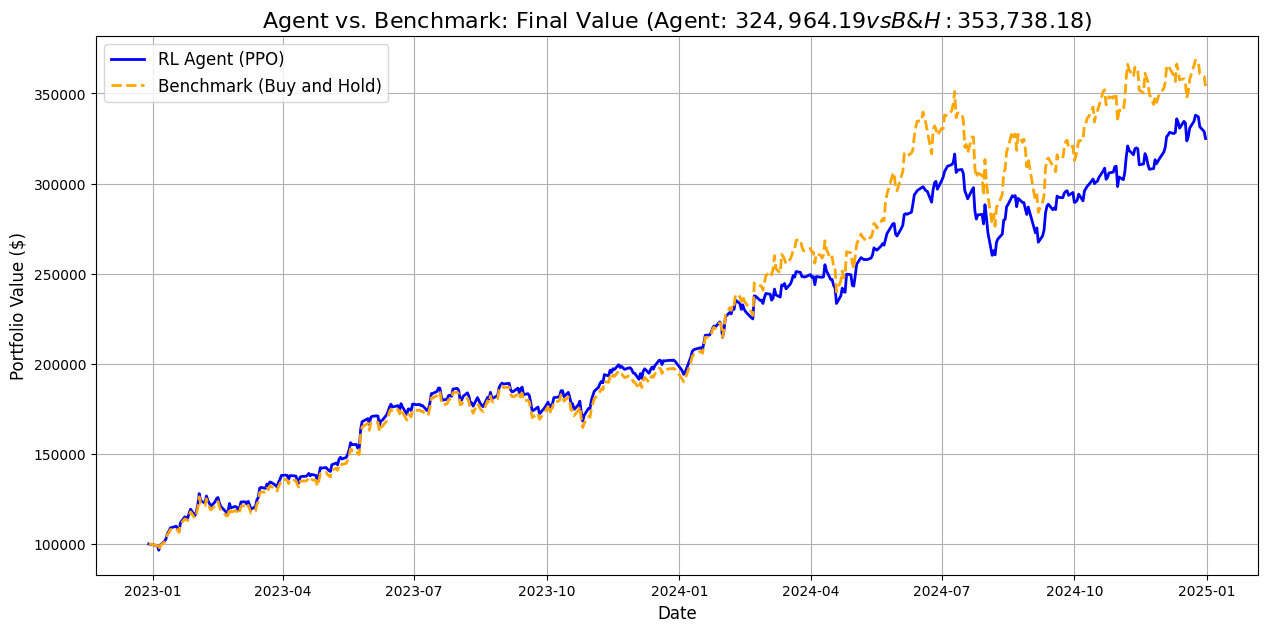

In [8]:
# --- 13. Plot Final Results: Agent vs. Benchmark ---

# Create a DataFrame for easy plotting
agent_history = pd.Series(agent_portfolio_history, index=test_df.index)

plt.figure(figsize=(15, 7))

# Plot the Agent's performance
plt.plot(agent_history, label='RL Agent (PPO)', color='blue', linewidth=2)

# Plot the Benchmark's performance
plt.plot(benchmark_history, label='Benchmark (Buy and Hold)', color='orange', linewidth=2, linestyle='--')

# Get final values for the title
agent_final_val_str = f"${agent_history.iloc[-1]:,.2f}"
bench_final_val_str = f"${benchmark_history.iloc[-1]:,.2f}"

# Formatting
plt.title(f'Agent vs. Benchmark: Final Value (Agent: {agent_final_val_str} vs B&H: {bench_final_val_str})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.show()

Based on our analysis, the agent's underperformance was likely due to insufficient training time, leading to an unsophisticated policy that incurred high transaction fees.

To test this hypothesis, we will now retrain a **new agent from scratch** with 10x the experience: **1,000,000 timesteps**.

This will give the agent ample opportunity to learn a more advanced policy that optimizes for long-term growth and potentially learns to minimize transaction costs by trading less frequently or more intelligently.

In [9]:
# --- 14. Re-train a New Model with 1,000,000 Timesteps ---

# We must re-instantiate the environment and model
# to ensure we are training from scratch.
train_env = DummyVecEnv([make_train_env])

# Define a new model
model_1M = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    tensorboard_log="./ppo_tensorboard_1M/"  # Use a new log directory
)

# Set the new timestep count
TOTAL_TIMESTEPS_1M = 1000000

print("--- Starting NEW Model Training (1,000,000 Timesteps) ---")
start_time = time.time()

# Train the new model
model_1M.learn(
    total_timesteps=TOTAL_TIMESTEPS_1M,
    progress_bar=True
)

end_time = time.time()
print("--- Training (1M) Complete ---")
print(f"Time to train: {(end_time - start_time):.2f} seconds")

# --- 15. Save the New (1M) Model ---
MODEL_PATH_1M = "ppo_trading_agent_v3_1M.zip"
model_1M.save(MODEL_PATH_1M)

print(f"New (1M) model saved to {MODEL_PATH_1M}")

Using cuda device
--- Starting NEW Model Training (1,000,000 Timesteps) ---
Logging to ./ppo_tensorboard_1M/PPO_1


Output()

A saída de streaming foi truncada nas últimas 5000 linhas.
|    std                  | 0.988        |
|    value_loss           | 8.45e+08     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 439          |
|    iterations           | 225          |
|    time_elapsed         | 1048         |
|    total_timesteps      | 460800       |
| train/                  |              |
|    approx_kl            | 0.0023243532 |
|    clip_fraction        | 0.00332      |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.03        |
|    explained_variance   | 0.00147      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.01e+09     |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.0011      |
|    std                  | 0.987        |
|    value_loss           | 2.42e+09     |
--------------------------------------

--- Training (1M) Complete ---
Time to train: 2269.89 seconds
New (1M) model saved to ppo_trading_agent_v3_1M.zip


With our new 1,000,000-timestep model trained, let's repeat the exact same backtest.

We will load `ppo_trading_agent_v3_1M.zip` and run it on the *exact same* test set (2023-2025). This will give us a direct comparison to see if the added training time improved the agent's performance.

In [10]:
# --- 16. Run Backtest on the 1M Timestep Model ---

# Load the NEW saved model
model_1M = PPO.load(MODEL_PATH_1M)
print("Saved model (1M) loaded successfully.")

# Re-instantiate the test environment for a clean backtest
test_env_backtest_1M = TradingEnv(test_df)
obs, _ = test_env_backtest_1M.reset()

print("--- Starting Backtest (1M Model) ---")
# Loop through the test data
terminated = False
truncated = False
while not (terminated or truncated):
    # Use deterministic=True for a consistent, non-random evaluation
    action, _states = model_1M.predict(obs, deterministic=True)

    # Take one step in the environment
    obs, reward, terminated, truncated, info = test_env_backtest_1M.step(action)

print("--- Backtest (1M Model) Complete ---")

# --- 17. Get the Agent's (1M) Performance History ---
agent_portfolio_history_1M = test_env_backtest_1M.portfolio_history

# Print the final value for a quick check
agent_final_value_1M = agent_portfolio_history_1M[-1]
print(f"  - Agent (1M) Final Value: ${agent_final_value_1M:,.2f}")
print(f"  - Benchmark Final Value: ${benchmark_history.iloc[-1]:,.2f}") # From earlier cell

Saved model (1M) loaded successfully.
--- Starting Backtest (1M Model) ---
--- Backtest (1M Model) Complete ---
  - Agent (1M) Final Value: $278,411.94
  - Benchmark Final Value: $353,738.18


This is a critical and fascinating result. The 1,000,000-timestep agent performed *worse* than the 100,000-timestep agent.

This strongly suggests **overfitting**.

The `model_1M` likely "memorized" the noise and specific patterns of the 2015-2022 training data. When exposed to the new (2023-2025) test data, that memorized policy was no longer effective and likely led to poor, high-fee trades.

The `model_100k` was simpler and learned a more "generalized" (less-fitted) policy, which, while still underperforming the benchmark, was more robust.

Let's visualize all three on one chart to confirm.

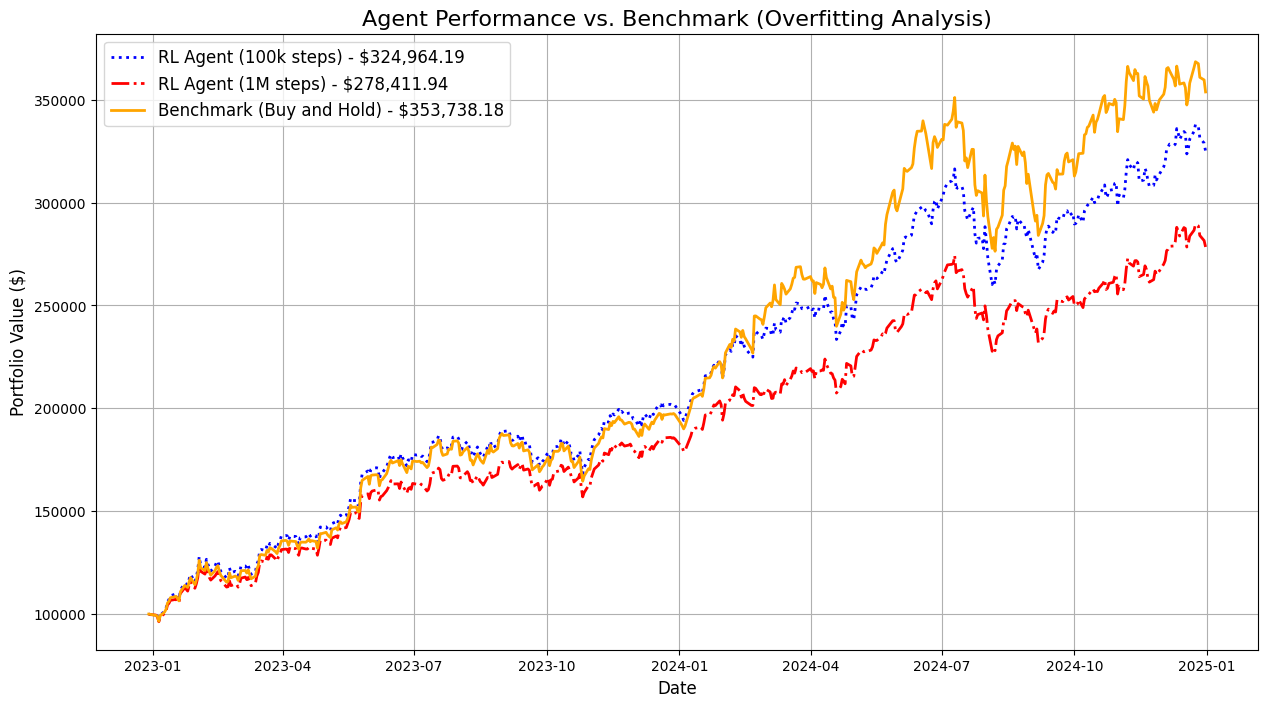

In [11]:
# --- 18. Plot Final Results: Both Agents vs. Benchmark ---

# Create pandas Series for all three histories
agent_100k_history = pd.Series(agent_portfolio_history, index=test_df.index)
agent_1M_history = pd.Series(agent_portfolio_history_1M, index=test_df.index)
# benchmark_history was already created as a Series

plt.figure(figsize=(15, 8))

# Plot the Agent's performance
plt.plot(agent_100k_history, label=f'RL Agent (100k steps) - ${agent_100k_history.iloc[-1]:,.2f}',
         color='blue', linewidth=2, linestyle=':')

plt.plot(agent_1M_history, label=f'RL Agent (1M steps) - ${agent_1M_history.iloc[-1]:,.2f}',
         color='red', linewidth=2, linestyle='-.')

# Plot the Benchmark's performance
plt.plot(benchmark_history, label=f'Benchmark (Buy and Hold) - ${benchmark_history.iloc[-1]:,.2f}',
         color='orange', linewidth=2)

# Formatting
plt.title('Agent Performance vs. Benchmark (Overfitting Analysis)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.show()

### Final Step: Exporting the Best Model to ONNX

As a final step, we will export our best-performing model (the 100k-step version) to the ONNX (Open Neural Network Exchange) format.

This converts the model's "policy" (its brain) into a standard, high-performance file. This ONNX file can then be loaded by other applications (e.g., in C++, C#, or a dedicated inference server) for live trading, completely independent of this Python notebook.

This demonstrates the full MLOps cycle from training to a production-ready asset.

In [13]:
# --- 1. Install ONNX libraries ---
!pip install onnx onnxruntime -q
print("ONNX libraries installed.")

import torch
import onnx
import onnxruntime
from google.colab import files

# --- 2. Define Model and File Names ---
MODEL_TO_EXPORT = "ppo_trading_agent_v3.zip"  # The 100k model
ONNX_FILE_PATH = "ppo_policy_100k.onnx"
ZIP_FILE_NAME = "ppo_trader_onnx.zip"

# --- 3. Load the Model and Get the Policy ---
try:
    # We need a base environment to get the obs space shape
    base_env = TradingEnv(test_df)
    observation_space_shape = base_env.observation_space.shape

    model_to_export = PPO.load(MODEL_TO_EXPORT, device='cpu')
    policy = model_to_export.policy
    policy.to("cpu") # Ensure the model is on the CPU for exporting

    print(f"Loaded model {MODEL_TO_EXPORT} for export.")
    print(f"Observation space shape: {observation_space_shape}")

except Exception as e:
    print(f"Error loading model: {e}")
    raise e

# --- 4. Create a Dummy Input Tensor ---
dummy_input = torch.randn(1, *observation_space_shape)

# --- 5. Export to ONNX ---
try:
    torch.onnx.export(
        policy,
        dummy_input,
        ONNX_FILE_PATH,
        export_params=True,
        opset_version=11,
        input_names=['input_observation'],
        output_names=['output_action']
    )
    print(f"\nSuccess! Model policy exported to {ONNX_FILE_PATH}")
except Exception as e:
    print(f"\nError exporting to ONNX: {e}")

# --- 6. Verify the ONNX Model (Optional but good practice) ---
try:
    onnx_model = onnx.load(ONNX_FILE_PATH)
    onnx.checker.check_model(onnx_model)
    print("ONNX model checked and verified.")
except Exception as e:
    print(f"ONNX model verification failed: {e}")


# --- 7. Zip the ONNX file ---
!zip -j {ZIP_FILE_NAME} {ONNX_FILE_PATH}

# --- 8. Download the zip file ---
print(f"\nZipping complete. Downloading {ZIP_FILE_NAME}...")
files.download(ZIP_FILE_NAME)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00
ONNX libraries installed.
Loaded model ppo_trading_agent_v3.zip for export.
Observation space shape: (11,)

Success! Model policy exported to ppo_policy_100k.onnx
ONNX model checked and verified.
  adding: ppo_policy_100k.onnx (deflated 14%)

Zipping complete. Downloading ppo_trader_onnx.zip...


/tmp/ipython-input-2215303256.py:37: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>